<a href="https://colab.research.google.com/github/Priyabratagni/DBMI_Demographic_Bias_in_Medical_Imaging/blob/main/EfficientNetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Requirements

In [3]:
! pip install torch torchvision timm scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Importing Required Libraries

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import timm
import torch.optim as optim

## Load the csv file and Image data

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DermaMNISTDataset.csv')
npz = np.load('/content/drive/MyDrive/Colab Notebooks/DermaMNIST_Corrected_224.npz')

In [6]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,train
1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,train
2,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,train
3,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,train
4,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern,train
...,...,...,...,...,...,...,...,...,...
10010,HAM_0007199,ISIC_0030344,akiec,histo,55.0,female,face,rosendahl,test
10011,HAM_0003934,ISIC_0027767,akiec,histo,85.0,male,back,rosendahl,test
10012,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,rosendahl,test
10013,HAM_0006902,ISIC_0031506,akiec,histo,70.0,male,hand,rosendahl,test


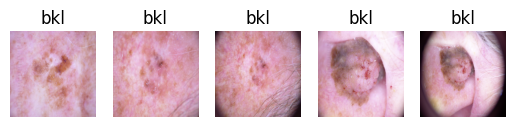

In [7]:
import matplotlib.pyplot as plt

colums_dx = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DermaMNISTDataset.csv')['dx']
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(npz['train_images'][i])
    plt.title(colums_dx[i])
    plt.axis('off')
plt.show()

Convert text classes to Numerical Format

In [8]:
label_encoder = LabelEncoder()
df['dx_enc'] = label_encoder.fit_transform(df['dx'])

In [9]:
class DermaDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32) / 255.0
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (2, 0, 1))
        label = self.labels[idx]
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [10]:
train_idx = df[df['split'] == 'train'].index
val_idx = df[df['split'] == 'val'].index
test_idx = df[df['split'] == 'test'].index

In [11]:
train_labels = df.loc[train_idx, 'dx_enc'].to_numpy()
val_labels = df.loc[val_idx, 'dx_enc'].to_numpy()
test_labels = df.loc[test_idx, 'dx_enc'].to_numpy()

In [12]:
trainset = DermaDataset(npz['train_images'], train_labels)
valset = DermaDataset(npz['val_images'], val_labels)
testset = DermaDataset(npz['test_images'], test_labels)

In [13]:
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(valset, batch_size=32)
test_loader = DataLoader(testset, batch_size=32)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('efficientnet_b1', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 7)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [16]:
num_epochs = 10

# Initialize lists to track metrics
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [17]:

    # --- Validation step ---
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    # APPEND metrics inside the loop!
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Train Loss: 0.0491 | Val Loss: 0.4359 | Val Acc: 0.8918


In [18]:
# ---- Test Evaluation ---- #
model.eval()
correct = 0
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
test_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8949


In [19]:
print("Epochs:", num_epochs)
print("Train Losses:", len(train_losses))
print("Val Losses:", len(val_losses))
print("Val Accuracies:", len(val_accuracies))

Epochs: 10
Train Losses: 1
Val Losses: 1
Val Accuracies: 1


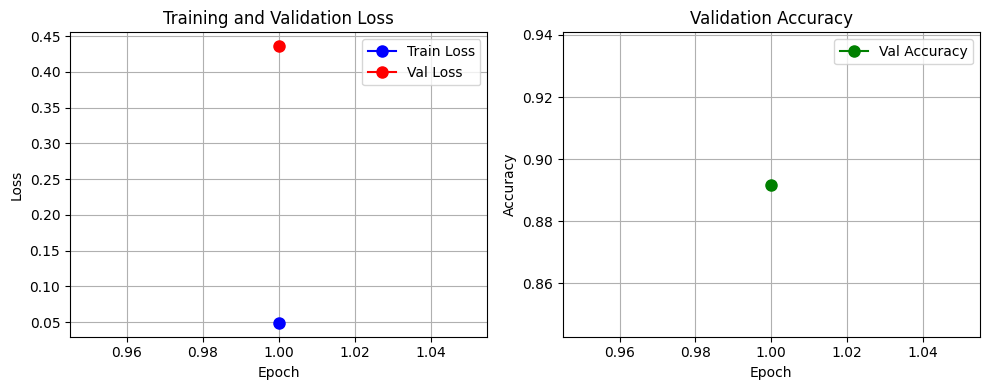

Completed epochs: 1
Train Loss: [0.049050935194445]
Val Loss: [0.4358664293583307]
Val Accuracy: [0.8917975567190227]


In [26]:
import matplotlib.pyplot as plt

completed_epochs = len(train_losses)
epochs_completed = range(1, completed_epochs + 1)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

plt.plot(epochs_completed, train_losses, 'bo-', label='Train Loss', markersize=8)
plt.plot(epochs_completed, val_losses, 'ro-', label='Val Loss', markersize=8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_completed, val_accuracies, 'go-', label='Val Accuracy', markersize=8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Completed epochs: {completed_epochs}")
print(f"Train Loss: {train_losses}")
print(f"Val Loss: {val_losses}")
print(f"Val Accuracy: {val_accuracies}")

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

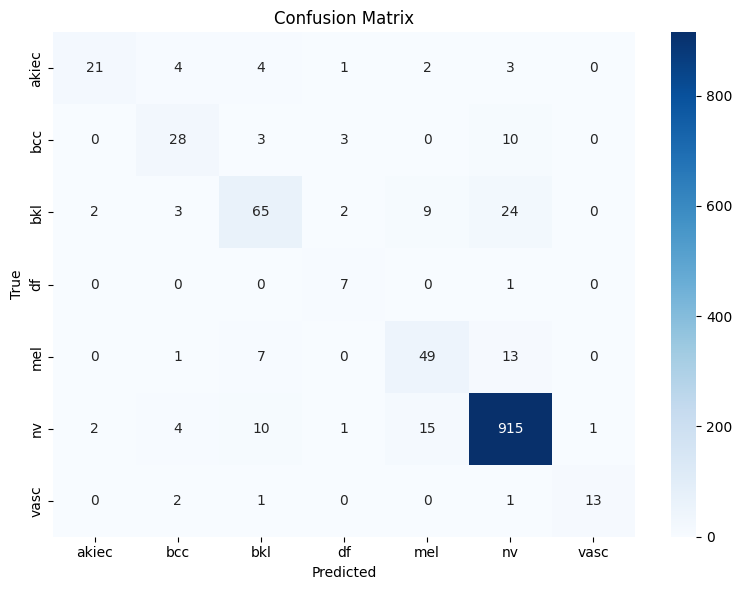

In [23]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [24]:
report = classification_report(
    all_labels,
    all_preds,
    target_names=label_encoder.classes_,
    digits=3
)
print(report)

              precision    recall  f1-score   support

       akiec      0.840     0.600     0.700        35
         bcc      0.667     0.636     0.651        44
         bkl      0.722     0.619     0.667       105
          df      0.500     0.875     0.636         8
         mel      0.653     0.700     0.676        70
          nv      0.946     0.965     0.956       948
        vasc      0.929     0.765     0.839        17

    accuracy                          0.895      1227
   macro avg      0.751     0.737     0.732      1227
weighted avg      0.894     0.895     0.893      1227



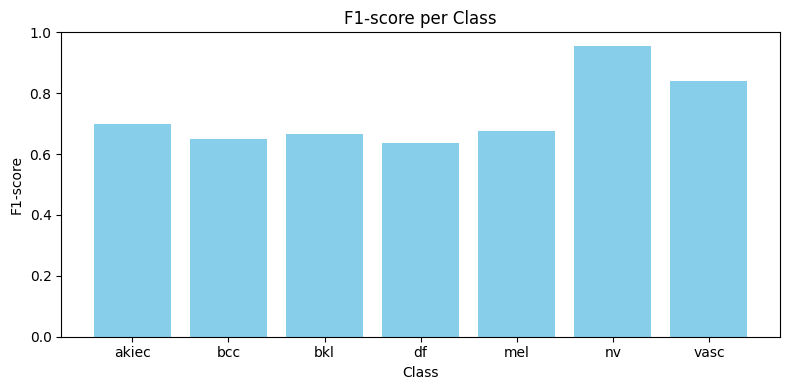

In [25]:
import numpy as np

report_dict = classification_report(
    all_labels, all_preds, target_names=label_encoder.classes_, output_dict=True
)
f1_scores = [report_dict[c]['f1-score'] for c in label_encoder.classes_]

plt.figure(figsize=(8,4))
plt.bar(label_encoder.classes_, f1_scores, color='skyblue')
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score per Class')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()